# Assignment 4 - Opsis

In [1]:
# Import necessary libraries
import tarfile
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

## 1 - Codebook Generation

In order to generate a code book, select a set of training images.

In [2]:
# Open the file
imgs = tarfile.open('caltech-101/101_ObjectCategories.tar.gz', 'r:gz')

# Create a dictionary for labeled images
labeled_imgs = defaultdict(list)

# Iterate over the images in the file and get the class labels from the image paths
for img in imgs.getmembers():
    if img.name.endswith('.jpg'):
        parts = img.name.split('/')
        _, label, _ = parts
        labeled_imgs[label].append(img)

In [3]:
# Pick 20 classes
train = []
test = []

# Iterate over all the classes and get the corresponding images
for c in list(labeled_imgs.keys())[:20]:
    img_c = labeled_imgs[c]
    random.shuffle(img_c)

    # Split into train and test sets
    n_train = len(img_c) // 2
    train_imgs = img_c[:n_train]
    test_imgs  = img_c[n_train:2*n_train]

    # Get the images for both sets and append to the lists
    for img in train_imgs:
        train.append((img, c))

    for img in test_imgs:
        test.append((img, c))

Then extract SIFT features from the training images (ignore position, orientation and scale). The SIFT features should be concatenated into a matrix, one descriptor per row.

In [4]:
all_descriptors_train = []

# Iterate over the training images
for i, label in train:
    file = imgs.extractfile(i)

    # Decode the image
    img_bytes = np.frombuffer(file.read(), np.uint8)
    img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply SIFT
    sift = cv2.SIFT_create()
    kp, dc = sift.detectAndCompute(gray, None)

    # Concatenate all descriptors into one matrix and filter invalid ones
    if dc is not None and dc.shape[1] == 128:
        all_descriptors_train.append(dc)

descriptors_train = np.vstack(all_descriptors_train)

Then you should run the k-means clustering algorithm on the subset of training descriptors to extract good prototype (visual word) clusters. A reasonable k should be small (say between 200 and 500) for a small number of categories (say 5) and larger (say between 500 and 2000) for a larger number of categories. Also, a good value of k may depend on the complexity of your data. You should experiment with a few different values of k (but beware that this can be rather time-consuming).

## Finding Optimal Codebook Size using Cross-Validation

In [5]:
def cross_validate_k(k_value, data, labels, imgs_archive, n_folds=10):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    fold_mrrs = []
    fold_top3s = []

    # Convert to arrays for easier indexing
    data_array = np.array(data, dtype=object)
    labels_array = np.array(labels)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(data_array)):
        # Split data
        train_fold = data_array[train_idx]
        val_fold = data_array[val_idx]
        train_labels_fold = labels_array[train_idx]
        val_labels_fold = labels_array[val_idx]

        # Extract descriptors from training fold
        all_descriptors = []
        for img_info, label in train_fold:
            file = imgs_archive.extractfile(img_info)
            img_bytes = np.frombuffer(file.read(), np.uint8)
            img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            sift = cv2.SIFT_create()
            _, dc = sift.detectAndCompute(gray, None)

            if dc is not None and dc.shape[1] == 128:
                all_descriptors.append(dc)

        descriptors_matrix = np.vstack(all_descriptors)

        # k-means
        kmeans = KMeans(n_clusters=k_value, random_state=42)
        kmeans.fit(descriptors_matrix)

        print('k-means done')
        # BoW for training fold
        bows_train = []
        for img_info, label in train_fold:
            file = imgs_archive.extractfile(img_info)
            img_bytes = np.frombuffer(file.read(), np.uint8)
            img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            sift = cv2.SIFT_create()
            kp, dc = sift.detectAndCompute(gray, None)

            if dc is not None and len(dc) > 0:
                words = kmeans.predict(dc)
                hist = np.bincount(words, minlength=k_value)
            else:
                hist = np.zeros(k_value, dtype=int)

            bows_train.append(hist)

        bows_train = np.array(bows_train)

        # BoW for val fold
        bows_val = []
        for img_info, label in val_fold:
            file = imgs_archive.extractfile(img_info)
            img_bytes = np.frombuffer(file.read(), np.uint8)
            img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            sift = cv2.SIFT_create()
            kp, dc = sift.detectAndCompute(gray, None)

            if dc is not None and len(dc) > 0:
                words = kmeans.predict(dc)
                hist = np.bincount(words, minlength=k_value)
            else:
                hist = np.zeros(k_value, dtype=int)

            bows_val.append(hist)

        bows_val = np.array(bows_val)

        # TF-IDF
        tfidf = TfidfTransformer(norm='l2', use_idf=True)
        tfidf_train = tfidf.fit_transform(bows_train)
        tfidf_val = tfidf.transform(bows_val)

        # evaluate on val fold
        ranks = []
        top3 = []

        for i in range(tfidf_val.shape[0]):
            similarities = cosine_similarity(tfidf_val[i], tfidf_train)[0]
            sorted_sim = np.argsort(similarities)[::-1]
            ordered_labels = train_labels_fold[sorted_sim]

            rank = np.where(ordered_labels == val_labels_fold[i])[0][0] + 1
            in_top3 = val_labels_fold[i] in ordered_labels[:3]

            ranks.append(rank)
            top3.append(in_top3)

        fold_mrr = np.mean([1.0 / r for r in ranks])
        fold_top3 = np.mean(top3) * 100

        fold_mrrs.append(fold_mrr)
        fold_top3s.append(fold_top3)
        print('fold done')

    # average across folds
    return np.mean(fold_mrrs), np.mean(fold_top3s)

In [6]:
k_values = range(700, 2000, 300)

cv_results = {
    'k': [],
    'cv_mrr': [],
    'cv_top3': []
}

# Prepare training data labels
train_labels = np.array([label for _, label in train])

print("Finding optimal codebook size using 5-fold cross-validation, 10 is too much...")

for k in k_values:
    print(f"Testing k={k}...")
    avg_mrr, avg_top3 = cross_validate_k(k, train, train_labels, imgs, n_folds=5)

    cv_results['k'].append(k)
    cv_results['cv_mrr'].append(avg_mrr)
    cv_results['cv_top3'].append(avg_top3)

    print(f"CV MRR: {avg_mrr:.4f}, CV Top-3: {avg_top3:.2f}%\n")

# find optimal k based on MRR
optimal_k_idx = np.argmax(cv_results['cv_mrr'])
optimal_k = cv_results['k'][optimal_k_idx]

print("-"*60)
print(f"Optimal k: {optimal_k}")
print(f"CV MRR: {cv_results['cv_mrr'][optimal_k_idx]:.4f}")
print(f"CV Top-3: {cv_results['cv_top3'][optimal_k_idx]:.2f}%")
print("-"*60)

Finding optimal codebook size using 5-fold cross-validation, 10 is too much...
Testing k=700...
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
CV MRR: 0.5042, CV Top-3: 58.61%

Testing k=1000...
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
CV MRR: 0.4899, CV Top-3: 57.31%

Testing k=1300...
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
CV MRR: 0.4883, CV Top-3: 56.81%

Testing k=1600...
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
CV MRR: 0.4899, CV Top-3: 55.70%

Testing k=1900...
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
k-means done
fold done
CV MRR: 0.4871, CV Top-3: 56.40%

------------------------------------------------------------
Optimal k: 700
CV MRR: 0.5

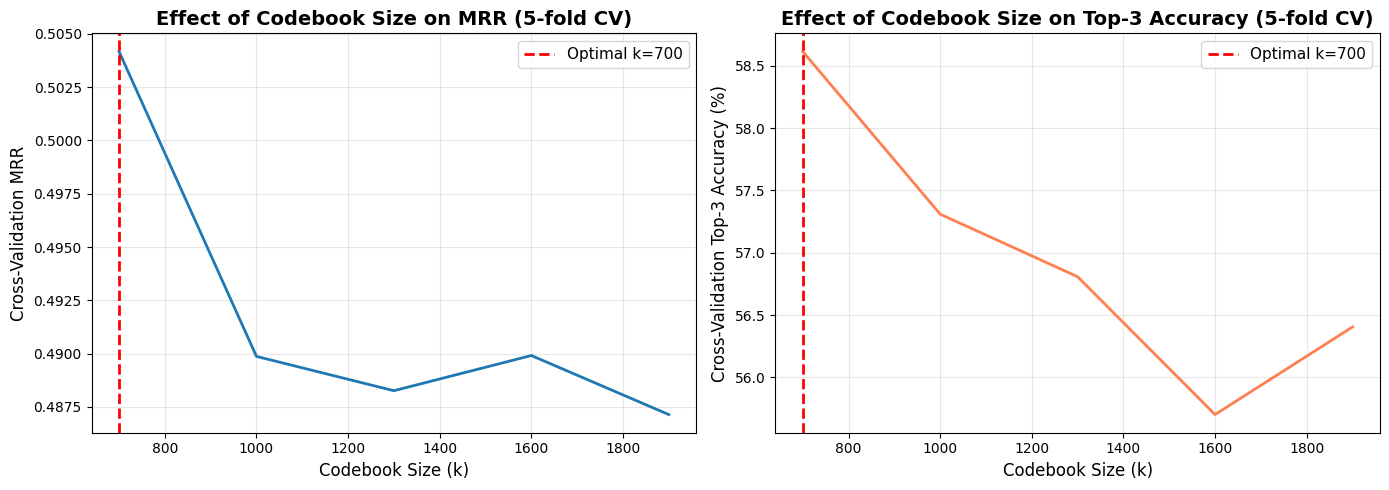

In [7]:
# plot cross-validation results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MRR
ax1.plot(cv_results['k'], cv_results['cv_mrr'], linewidth=2, markersize=8)
ax1.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal k={optimal_k}')
ax1.set_xlabel('Codebook Size (k)', fontsize=12)
ax1.set_ylabel('Cross-Validation MRR', fontsize=12)
ax1.set_title('Effect of Codebook Size on MRR (5-fold CV)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Top-3 Accuracy
ax2.plot(cv_results['k'], cv_results['cv_top3'], linewidth=2, markersize=8, color='coral')
ax2.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal k={optimal_k}')
ax2.set_xlabel('Codebook Size (k)', fontsize=12)
ax2.set_ylabel('Cross-Validation Top-3 Accuracy (%)', fontsize=12)
ax2.set_title('Effect of Codebook Size on Top-3 Accuracy (5-fold CV)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Once clustering has been obtained, classify each training descriptor to the closest cluster centers, and form the bag of words (BoW) for each image in the image training set.

## Training Final Model with Optimal k

In [8]:
# Train k-means with optimal k on all training descriptors
print(f"Training final k-means model with k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(descriptors_train)

Training final k-means model with k=700...


,n_clusters,700
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [9]:
# Build BoW for training images with optimal k
all_bow_features_train = []

for i, label in train:
    file = imgs.extractfile(i)
    
    # Decode the image
    img_bytes = np.frombuffer(file.read(), np.uint8)
    img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply SIFT
    sift = cv2.SIFT_create()
    kp, dc = sift.detectAndCompute(gray, None)
    
    # Build histogram of visual words
    if dc is not None and len(dc) > 0:
        train_words = kmeans.predict(dc)
        train_hist = np.bincount(train_words, minlength=optimal_k)
    else:
        train_hist = np.zeros(optimal_k, dtype=int)
    
    all_bow_features_train.append(train_hist)

bows_train = np.array(all_bow_features_train)
labels_train = np.array([label for _, label in train])

print(f"Training BoW shape: {bows_train.shape}")

Training BoW shape: (1991, 700)


## 2 - Indexing

The next step consists in content indexing. For each image in the test set you should:

- Extract the SIFT descriptors of the feature points in the image,
- Project the descriptors onto the codebook, i.e., for each descriptor the closest cluster prototype should be found,
- Construct the generated corresponding bag of words, i.e, word histogram.

In [10]:
all_bow_features_test = []

for i, label in test:
    file = imgs.extractfile(i)
    
    img_bytes = np.frombuffer(file.read(), np.uint8)
    img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kp, dc = sift.detectAndCompute(gray, None)
    
    if dc is not None and len(dc) > 0:
        test_words = kmeans.predict(dc)
        test_hist = np.bincount(test_words, minlength=optimal_k)
    else:
        test_hist = np.zeros(optimal_k, dtype=int)
    
    all_bow_features_test.append(test_hist)

bows_test = np.array(all_bow_features_test)
labels_test = np.array([label for _, label in test])

print(f"Test BoW shape: {bows_test.shape}")

Test BoW shape: (1991, 700)


## 3 - Retrieval

Finally, you should implement retrieving of images using some of the similarity measures discussed in the course slides. You may use:

- common words
- tf-ifd similarity
- Bhattacharyya distance or Kullback-Leibler divergence

### TF-IDF Similarity

In [11]:
# Apply TF-IDF transformation
tfidf = TfidfTransformer(norm='l2', use_idf=True)
tfidf_train = tfidf.fit_transform(bows_train)
tfidf_test = tfidf.transform(bows_test)

In [12]:
def retrieve(img_tfidf, img_label, data_tfidf, data_labels, top_k=3):

    # Compute the cosine similarity
    similarities = cosine_similarity(img_tfidf, data_tfidf)[0]

    # Sort by similarity and get ordered labels
    sorted_sim = np.argsort(similarities)[::-1]
    ordered_labels = data_labels[sorted_sim]

    # Get the rank and check if it is in top-k
    rank = np.where(ordered_labels == img_label)[0][0] + 1
    in_top_k = img_label in ordered_labels[:top_k]

    return rank, in_top_k

In [13]:
# Create empty lists for storage
ranks_train = []
top3_train = []
mrr_train_per_category = defaultdict(list)
top3_train_per_category = defaultdict(list)

# Iterate over the training images and retrieve
for i in range(tfidf_train.shape[0]):
    rank, in_top3 = retrieve(
        tfidf_train[i],
        labels_train[i],
        tfidf_train,
        labels_train,
        top_k=3
)

    ranks_train.append(rank)
    top3_train.append(in_top3)

    # Store the MRR per category
    category_train = labels_train[i]
    mrr_train_per_category[category_train].append(1.0 / rank)
    top3_train_per_category[category_train].append(in_top3)

# Get the overall mean reciprocal rank and top-3 accuracy
mrr_train = np.mean([1.0 / r for r in ranks_train])
top3_percent_train = np.mean(top3_train) * 100

# Get the mean reciprocal rank and top-3 accuracy per category
mrr_train_categories = sorted(mrr_train_per_category.keys())
mrr_train_all = [np.mean(mrr_train_per_category[c]) for c in mrr_train_categories]
top3_train_all = [np.mean(top3_train_per_category[c]) * 100 for c in mrr_train_categories]

print(f"MRR in Training: {mrr_train:.4f}")
print(f"Correct category in top-3: {top3_percent_train:.2f}%")

MRR in Training: 1.0000
Correct category in top-3: 100.00%


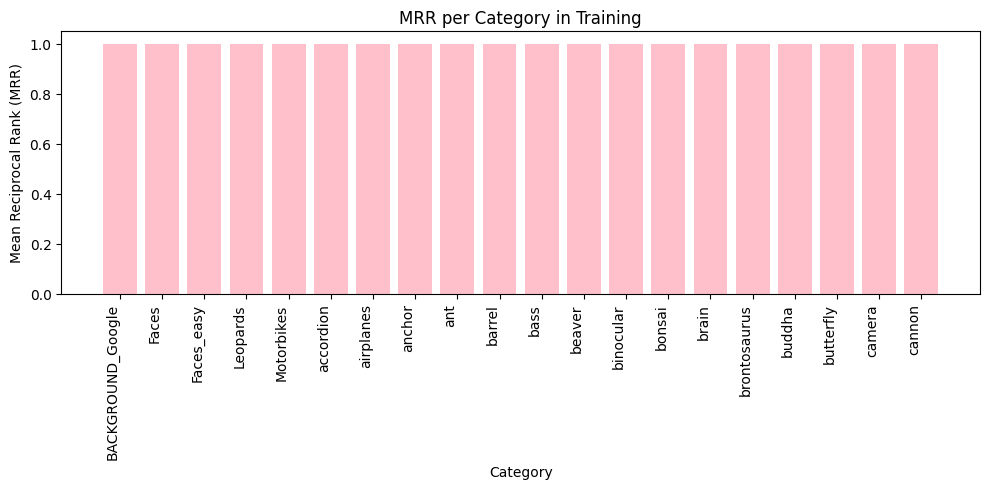

In [14]:
# Plot MRR per category
plt.figure(figsize=(10, 5))
plt.bar(mrr_train_categories, mrr_train_all, color='pink')
plt.xlabel("Category")
plt.ylabel("Mean Reciprocal Rank (MRR)")
plt.title("MRR per Category in Training")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

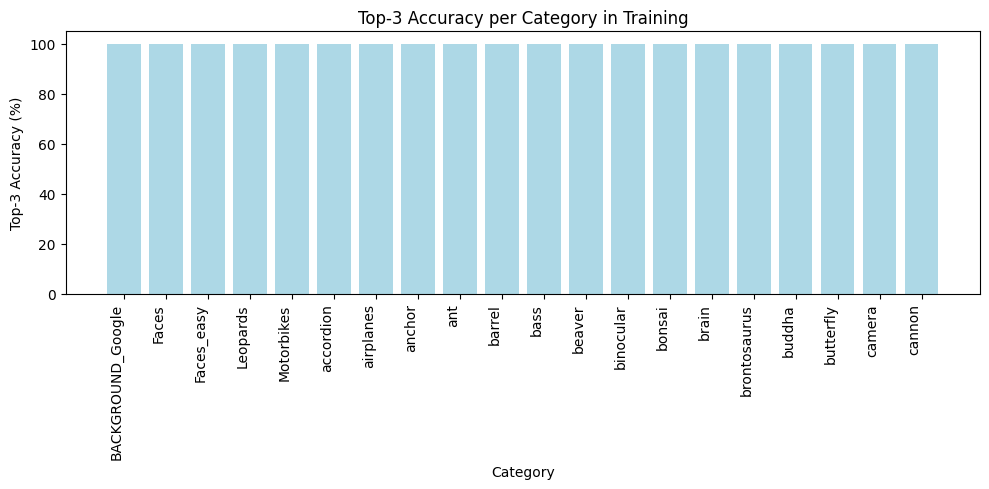

In [15]:
# Plot Top-3 Accuracy per category
plt.figure(figsize=(10, 5))
plt.bar(mrr_train_categories, top3_train_all, color='lightblue')
plt.xlabel("Category")
plt.ylabel("Top-3 Accuracy (%)")
plt.title("Top-3 Accuracy per Category in Training")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [16]:
# Create empty lists for storage
ranks_test = []
top3_test = []
mrr_test_per_category = defaultdict(list)
top3_test_per_category = defaultdict(list)

# Iterate over the testing images and retrieve
for i in range(tfidf_test.shape[0]):
    rank, in_top3 = retrieve(
        tfidf_test[i],
        labels_test[i],
        tfidf_train,
        labels_train,
        top_k=3
)

    ranks_test.append(rank)
    top3_test.append(in_top3)

    # Store the MRR per category
    category_test = labels_test[i]
    mrr_test_per_category[category_test].append(1.0 / rank)
    top3_test_per_category[category_test].append(in_top3)

# Get the overall mean reciprocal rank and top-3 accuracy
mrr_test = np.mean([1.0 / r for r in ranks_test])
top3_percent_test = np.mean(top3_test) * 100

# Get the mean reciprocal rank per category
mrr_test_categories = sorted(mrr_test_per_category.keys())
mrr_test_all = [np.mean(mrr_test_per_category[c]) for c in mrr_test_categories]
top3_test_all = [np.mean(top3_test_per_category[c]) * 100 for c in mrr_test_categories]

print(f"MRR in Testing: {mrr_test:.4f}")
print(f"Correct category in top-3: {top3_percent_test:.2f}%")

MRR in Testing: 0.5112
Correct category in top-3: 59.02%


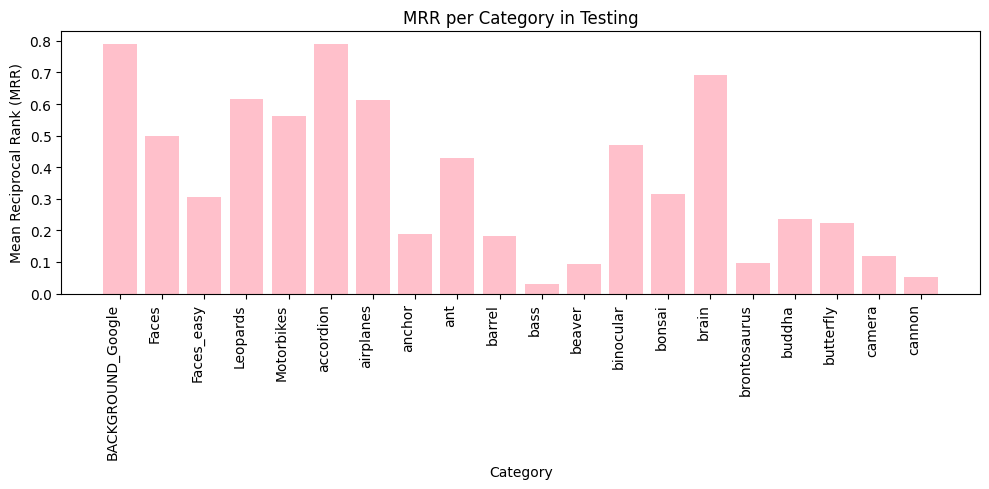

In [17]:
# Plot MRR per category
plt.figure(figsize=(10, 5))
plt.bar(mrr_test_categories, mrr_test_all, color='pink')
plt.xlabel("Category")
plt.ylabel("Mean Reciprocal Rank (MRR)")
plt.title("MRR per Category in Testing")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

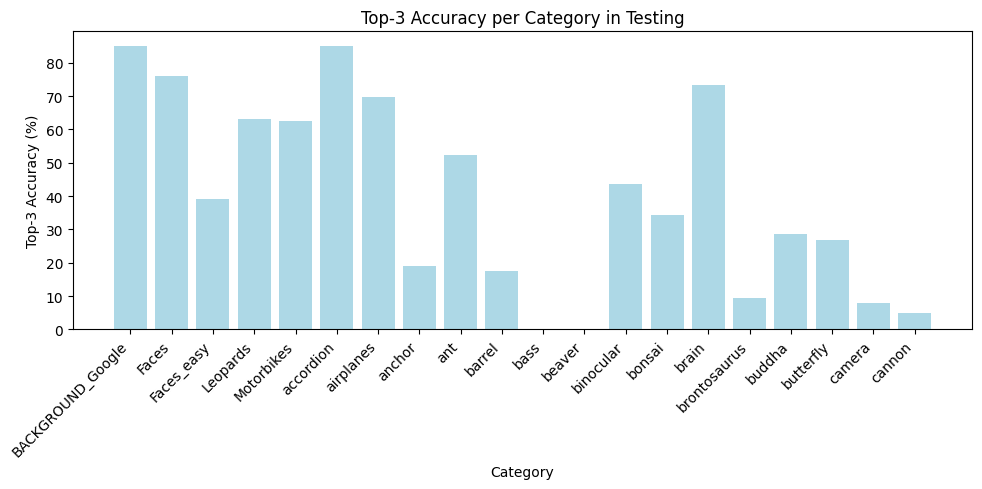

In [18]:
# Plot Top-3 Accuracy per category
plt.figure(figsize=(10, 5))
plt.bar(mrr_test_categories, top3_test_all, color='lightblue')
plt.xlabel("Category")
plt.ylabel("Top-3 Accuracy (%)")
plt.title("Top-3 Accuracy per Category in Testing")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()